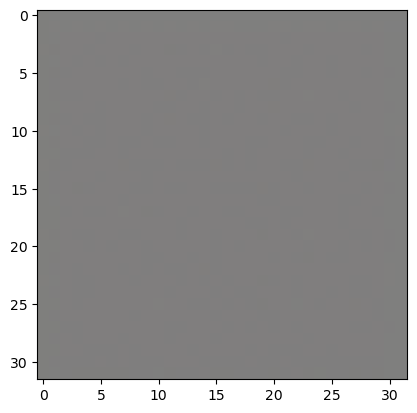

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=2)
        self.norm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=2)
        self.norm2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=2)
        self.norm3 = nn.BatchNorm2d(128)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(3200, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = F.leaky_relu(x, 0.2)
        x = self.conv2(x)
        x = self.norm2(x)
        x = F.leaky_relu(x, 0.2)
        x = self.conv3(x)
        x = self.norm3(x)
        x = F.leaky_relu(x, 0.2)
        x = self.flatten(x)
        x = F.dropout(x, 0.5)
        x = self.linear1(x)
        x = F.sigmoid(x)
        return x


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.linear1 = nn.Linear(64, 64 * 4 * 4)
        self.conv1 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.ConvTranspose2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(256, 3, kernel_size=5, stride=1, padding=2)

    def forward(self, x):
        x = self.linear1(x)
        x = x.view(-1, 64, 4, 4)
        x = self.conv1(x)
        x = F.leaky_relu(x, 0.2)
        x = self.conv2(x)
        x = F.leaky_relu(x, 0.2)
        x = self.conv3(x)
        x = F.leaky_relu(x, 0.2)
        x = self.conv4(x)
        x = torch.tanh(x)
        return x


discriminator = Discriminator().to(device)
generator = Generator().to(device)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.000001)
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.00001)

# test_vectors = torch.randn(25, 64, device=device)
# torch.save(test_vectors, 'test_vectors.pt')
test_vectors = torch.load("test_vectors.pt")

y = generator.forward(torch.randn(64, device=device))
plt.imshow(y[0].cpu().detach().numpy().transpose(1, 2, 0) / 2 + 0.5)

In [18]:
import os
from torchvision import transforms


def load_dataset():
    transform = transforms.Compose(
        [
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
            lambda x: x * 2 - 1,
        ]
    )

    true_images = []
    for f in os.listdir("crawled_cakes"):
        img = Image.open(os.path.join("crawled_cakes", f))
        img = transform(img)
        true_images.append(img)

    true_images = torch.stack(true_images)
    true_images_dataset = true_images.to(device)
    return true_images_dataset


true_images_dataset = load_dataset()

train_loader = torch.utils.data.DataLoader(
    true_images_dataset, batch_size=16, shuffle=True
)

In [3]:
# class Minimodel(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.lin = nn.Linear(2, 2)
#         self.lin2 = nn.Linear(2, 2)

#     def forward(self, x):
#         x = self.lin(x)
#         x = self.lin2(x)
#         return x


# minimodel = Minimodel()
# input_val = torch.randn(10, 2)
# loss_fn = lambda x: ((x - 42) ** 2).sum()
# optimizer = torch.optim.SGD(minimodel.lin.parameters(), lr=0.01)

# for i in range(20):
#     optimizer.zero_grad()
#     pred = minimodel(input_val)
#     loss = loss_fn(pred)

#     loss.backward()

#     optimizer.step()

#     print(pred)
#     print("Loss:", loss.item())

In [ ]:
starting_epoch = 0
path = f"models/epoch_{starting_epoch}"
# load model

generator.load_state_dict(torch.load(os.path.join(path, "generator.pt")))
discriminator.load_state_dict(torch.load(os.path.join(path, "discriminator.pt")))
generator_optimizer.load_state_dict(
    torch.load(os.path.join(path, "generator_optimizer.pt"))
)
discriminator_optimizer.load_state_dict(
    torch.load(os.path.join(path, "discriminator_optimizer.pt"))
)


In [19]:
def discriminator_batch(true_images):
    true_length = true_images.shape[0]

    generated_images = generator.forward(torch.randn(true_length, 64, device=device))
    batch = torch.cat([true_images, generated_images])

    labels = torch.cat([torch.ones(true_length), torch.zeros(true_length)]).to(device)
    random_noise = torch.rand(2 * true_length, device=device) * 0.1 - 0.05
    labels = labels + random_noise
    labels = torch.max(labels, torch.zeros(2 * true_length, device=device))
    labels = torch.min(labels, torch.ones(2 * true_length, device=device))
    labels = torch.unsqueeze(labels, 1)
    return batch, labels


def monitor_and_save(epoch, discriminator_losses, generator_losses, modelpath="models"):
    path = f"{modelpath}/epoch_{epoch}"
    os.makedirs(path, exist_ok=True)
    os.makedirs(f"{modelpath}/images", exist_ok=True)
    torch.save(generator.state_dict(), os.path.join(path, "generator.pt"))
    torch.save(discriminator.state_dict(), os.path.join(path, "discriminator.pt"))
    torch.save(
        generator_optimizer.state_dict(), os.path.join(path, "generator_optimizer.pt")
    )
    torch.save(
        discriminator_optimizer.state_dict(),
        os.path.join(path, "discriminator_optimizer.pt"),
    )

    generated_images = generator.forward(test_vectors)
    fig, ax = plt.subplots(5, 5, figsize=(10, 10))
    for i in range(5):
        for j in range(5):
            ax[i, j].imshow(
                generated_images[i * 5 + j].cpu().detach().numpy().transpose(1, 2, 0)
                / 2
                + 0.5
            )
            ax[i, j].axis("off")

    plt.savefig(os.path.join(path, "generated_images.png"))
    plt.savefig(f"{modelpath}/images/epoch_{epoch}.png")
    plt.close()

    with open(os.path.join(path, "losses.txt"), "w") as f:
        f.write(str(discriminator_losses))
        f.write("\n")
        f.write(str(generator_losses))
        f.write("\n")

In [20]:
for epoch in range(3000):
    print(f"Epoch {epoch}")
    disc_losses = []
    gen_losses = []
    for ib, image_batch in enumerate(train_loader):
        # train discriminator on true images
        batch, labels = discriminator_batch(true_images=image_batch)
        discriminator_optimizer.zero_grad()
        pred = discriminator(batch)
        loss = F.binary_cross_entropy(pred, labels)
        loss.backward()
        discriminator_optimizer.step()
        disc_losses.append(loss.item())


        # train discriminator on generated images


        # train generator
        batch = generator.forward(torch.randn(16, 64, device=device))
        generator_optimizer.zero_grad()
        pred = discriminator(batch)
        target = torch.ones((pred.shape[0], 1), device=device)
        loss = F.binary_cross_entropy(pred, target)
        loss.backward()
        generator_optimizer.step()
        gen_losses.append(loss.item())

    mean_disc_loss = sum(disc_losses) / len(disc_losses)
    mean_gen_loss = sum(gen_losses) / len(gen_losses)
    print("Discriminator loss: %.7f" % mean_disc_loss)
    print("Generator loss: %.7f" % mean_gen_loss)

    if (
        epoch < 10
        and epoch % 1 == 0
        or epoch < 100
        and epoch % 10 == 0
        or epoch % 20 == 0
    ):
        monitor_and_save(epoch, mean_disc_loss, mean_gen_loss, modelpath="models_2")

Epoch 0
Discriminator loss: 0.6270557
Generator loss: 0.2821323
Epoch 1
Discriminator loss: 0.5582255
Generator loss: 0.0955078
Epoch 2
Discriminator loss: 0.5061238
Generator loss: 0.0609406
Epoch 3
Discriminator loss: 0.4573798
Generator loss: 0.0409001
Epoch 4
Discriminator loss: 0.4130688
Generator loss: 0.0308029
Epoch 5
Discriminator loss: 0.3800219
Generator loss: 0.0240753
Epoch 6
Discriminator loss: 0.3481302
Generator loss: 0.0193982
Epoch 7
Discriminator loss: 0.3204519
Generator loss: 0.0159096
Epoch 8
Discriminator loss: 0.2920838
Generator loss: 0.0141363
Epoch 9
Discriminator loss: 0.2711357
Generator loss: 0.0126275
Epoch 10
Discriminator loss: 0.2531078
Generator loss: 0.0103027
Epoch 11
Discriminator loss: 0.2354126
Generator loss: 0.0094235
Epoch 12
Discriminator loss: 0.2220656
Generator loss: 0.0085251
Epoch 13
Discriminator loss: 0.2081353
Generator loss: 0.0076766
Epoch 14
Discriminator loss: 0.1948107
Generator loss: 0.0067638
Epoch 15
Discriminator loss: 0.1886

KeyboardInterrupt: 

In [16]:
def visualize_losses(sourcepath="model_2"):
    values = []
    for dir in os.listdir(sourcepath):
        if not dir.startswith("epoch_"):
            continue
        path = os.path.join(sourcepath, dir)
        epoch = int(dir.split("_")[1])

        with open(os.path.join(path, "losses.txt"), "r") as f:
            disc_loss = float(f.readline().split()[0])
            gen_loss = float(f.readline().split()[0])

        values.append((epoch, disc_loss, gen_loss))

    values.sort(key=lambda x: x[0])
    epochs = [x[0] for x in values]
    disc_losses = [x[1] for x in values]
    gen_losses = [x[2] for x in values]

    fix, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.plot(epochs, disc_losses, label="Discriminator loss")
    ax.plot(epochs, gen_losses, label="Generator loss")
    ax.legend()
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    plt.savefig("losses.png")
    plt.show()


visualize_losses()

FileNotFoundError: [Errno 2] No such file or directory: 'model_2'